# Setup

## Imports

In [238]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

## Set Parameters

NOTE: 1m data is only retrievable for the last 7 days, and any interval <1d is only for the last 60 days

In [239]:
# Dates are for training period
startDate = "2025-6-23"
endDate = "2025-6-25"
symbol1 = "PEP"
symbol2 = "KO"
timeInterval = "1m"

## Setup Data

In [240]:
# Download data for two stocks between specified dates with specified interval
data = yf.download([symbol1, symbol2], start=startDate, end=endDate, interval=timeInterval, auto_adjust=True)
# Get adjusted close prices
close = data["Close"].dropna()
close

[*********************100%***********************]  2 of 2 completed


Ticker,KO,PEP
Datetime,,
2025-06-23 13:30:00+00:00,68.995003,128.955002
2025-06-23 13:31:00+00:00,69.209999,129.225006
2025-06-23 13:32:00+00:00,69.300003,129.102005
2025-06-23 13:33:00+00:00,69.345001,129.205002
2025-06-23 13:34:00+00:00,69.330002,129.020004
...,...,...
2025-06-24 19:55:00+00:00,70.184998,131.100006
2025-06-24 19:56:00+00:00,70.199997,131.085007
2025-06-24 19:57:00+00:00,70.190002,131.100006


# Engle-Granger Test

## Imports

In [241]:
from statsmodels.tsa.stattools import adfuller

## Create Least Squares Linear Model and Get Residuals

In [257]:
# Convert prices from DataFrame to NumPy arrays
X = close[symbol1].to_numpy()
Y = close[symbol2].to_numpy()
# Regress Y on X
X_with_const = np.column_stack((np.ones(X.shape[0]), X))
beta, _, _, _ = np.linalg.lstsq(X_with_const, Y, rcond=None)
# Calculate residuals
residuals = Y - (beta[0] + beta[1] * X)
residuals

array([-0.18274848, -0.14320798, -0.25109661, -0.38001921, -0.28509056,
       -0.28700138, -0.26654432, -0.22252746, -0.25892105, -0.27686619,
       -0.26517963, -0.22388213, -0.22634988, -0.23404572, -0.19123388,
       -0.1513453 , -0.19203302, -0.18593436, -0.17258567, -0.03728903,
        0.02709154,  0.02014298,  0.04475667,  0.08951852,  0.09812857,
        0.12605508,  0.11261152,  0.10972441,  0.10815289,  0.06634353,
        0.082462  ,  0.02485336,  0.08501237,  0.10871732,  0.12832612,
        0.08449148,  0.10702081,  0.12410455,  0.11803711,  0.06547147,
        0.08994915,  0.04410272,  0.03050088,  0.04111726,  0.04678779,
        0.03319185,  0.0131952 ,  0.05133039,  0.06105789,  0.06956466,
        0.0967034 ,  0.11547157,  0.12238727,  0.12384976,  0.13716026,
        0.1476141 ,  0.13170706,  0.12898932,  0.17267719,  0.14306626,
        0.12683077,  0.1392664 ,  0.11329387,  0.11446208,  0.09774072,
        0.11320053,  0.1307326 ,  0.09111953,  0.08904726,  0.06

## Plot Residuals

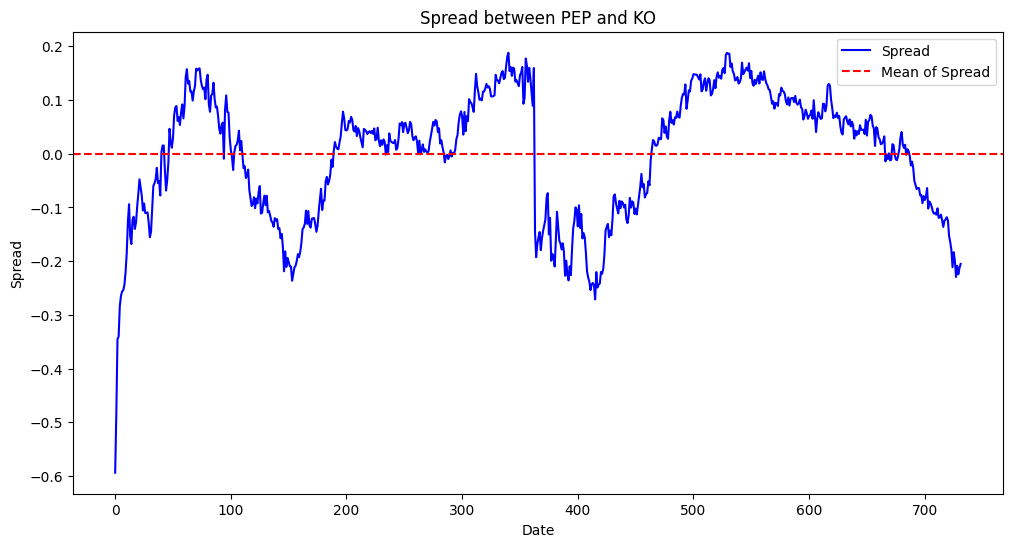

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(residuals, label='Spread', color='blue')
plt.axhline(residuals.mean(), color='red', linestyle='--', label='Mean of Spread')
plt.title(f'Spread between {symbol1} and {symbol2}')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.legend()
plt.show() 

## Perform Augmented Dickey-Fuller Test

In [ ]:
adfuller_result = adfuller(residuals)
# Print the ADF test statistic and p-value
print(f"ADF Test Statistic: {adfuller_result[0]}")
print(f"p-value: {adfuller_result[1]}")

ADF Test Statistic: -4.084851285394826
p-value: 0.001025897846442284


# Backtesting

In [246]:
testStartDate = "2025-6-25"
testEndDate = "2025-6-27"

In [247]:
# Download data for two stocks between specified dates with specified interval
data = yf.download([symbol1, symbol2], start=testStartDate, end=testEndDate, interval=timeInterval, auto_adjust=True)
# Get adjusted close prices
close = data["Close"].dropna()
close

[*********************100%***********************]  2 of 2 completed


Ticker,KO,PEP
Datetime,,
2025-06-25 13:30:00+00:00,69.889999,130.304993
2025-06-25 13:31:00+00:00,69.949997,130.375000
2025-06-25 13:32:00+00:00,69.714996,129.940002
2025-06-25 13:33:00+00:00,69.570000,129.884995
2025-06-25 13:34:00+00:00,69.699997,130.005005
...,...,...
2025-06-26 19:55:00+00:00,69.434998,128.204803
2025-06-26 19:56:00+00:00,69.480003,128.264999
2025-06-26 19:57:00+00:00,69.489998,128.250000


In [248]:
def zscore(series):
    """
    Calculate the z-score of a series. Uses rolling mean and standard deviation over a 60-period window to avoid lookahead bias.
    
    Args:
        series (pd.Series): The input series to calculate the z-score for.
    
    Returns:
        float: The z-score of the series.
    """
    rolling_mean = series.rolling(window=60).mean()
    rolling_std = series.rolling(window=60).std()
    zscore = (series - rolling_mean) / rolling_std
    return zscore

In [ ]:
def backtest(spread, entry_threshold=2.0, exit_threshold=0.5):
    """
    Backtest a pairs trading strategy based on the spread z-score.
    
    Args:
        spread (pd.Series): The spread series.
        entry_threshold (float): The z-score threshold for opening a position.
        exit_threshold (float): The z-score threshold for closing a position.
    
    Returns:
        pd.DataFrame: A DataFrame with the backtest results.
    """
    signals = pd.DataFrame(index=pd.RangeIndex(len(spread)), columns=['zscore', 'long_entry', 'short_entry', 'exit'])
    signals['zscore'] = zscore(spread)
    signals['long_entry'] = signals['zscore'] < -entry_threshold
    signals['short_entry'] = signals['zscore'] > entry_threshold
    signals['exit'] = (signals['zscore'] > -exit_threshold) & (signals['zscore'] < exit_threshold)
    
    return signals

In [321]:
import pandas as pd

def simulate_trading(signals, close, symbol1, symbol2, beta, slippage=0.0005, fees=0.0005):
    """
    Simulate trading based on generated signals.

    Args:
        signals (pd.DataFrame): DataFrame with 'long_entry', 'short_entry', 'exit' columns.
        close (pd.DataFrame): DataFrame with close prices for both symbols.
        symbol1 (str): First symbol.
        symbol2 (str): Second symbol.
        slippage (float): Slippage percentage for entry/exit prices.
        fees (float): Percentage fees for trading.
    Returns:
        pd.DataFrame: DataFrame with trades and daily P&L.
    """
    in_trade = False
    entry_type = None
    entry_price_x = entry_price_y = 0
    entry_index = None
    trade_pnls = []
    equity_curve = []
    cumulative_pnl = 0

    hedge_ratio = beta[1]

    for i in range(1, len(signals)):
        price_x = close[symbol1].iloc[i]
        price_y = close[symbol2].iloc[i]

        if not in_trade:
            if signals['long_entry'].iloc[i]:
                in_trade = True
                entry_type = 'long'
                entry_price_x = price_x * (1 - slippage)
                entry_price_y = price_y * (1 + slippage)
                entry_index = i

            elif signals['short_entry'].iloc[i]:
                in_trade = True
                entry_type = 'short'
                entry_price_x = price_x * (1 + slippage)
                entry_price_y = price_y * (1 - slippage)
                entry_index = i

        elif in_trade and signals['exit'].iloc[i]:
            exit_price_x = price_x * (1 - slippage if entry_type == 'long' else 1 + slippage)
            exit_price_y = price_y * (1 + slippage if entry_type == 'long' else 1 - slippage)

            # Calculate percentage returns
            ret_x = (exit_price_x - entry_price_x) / entry_price_x
            ret_y = (exit_price_y - entry_price_y) / entry_price_y

            # PnL in return space
            if entry_type == 'long':
                pnl = ret_y - hedge_ratio * ret_x
            elif entry_type == 'short':
                pnl = -ret_y + hedge_ratio * ret_x

            # Fees: 2 legs × 2 sides (entry & exit)
            total_fees = 4 * fees  # each leg: entry + exit

            net_pnl = pnl - total_fees
            cumulative_pnl += net_pnl

            trade_pnls.append({
                'entry_type': entry_type,
                'entry_index': entry_index,
                'exit_index': i,
                'gross_return': pnl,
                'fees': total_fees,
                'net_return': net_pnl
            })

            in_trade = False
            entry_type = None

        equity_curve.append(cumulative_pnl)

    # Finalize results
    results = signals.copy()
    results['equity'] = pd.Series(equity_curve, index=signals.index[:len(equity_curve)])
    trades_df = pd.DataFrame(trade_pnls)

    return results, trades_df

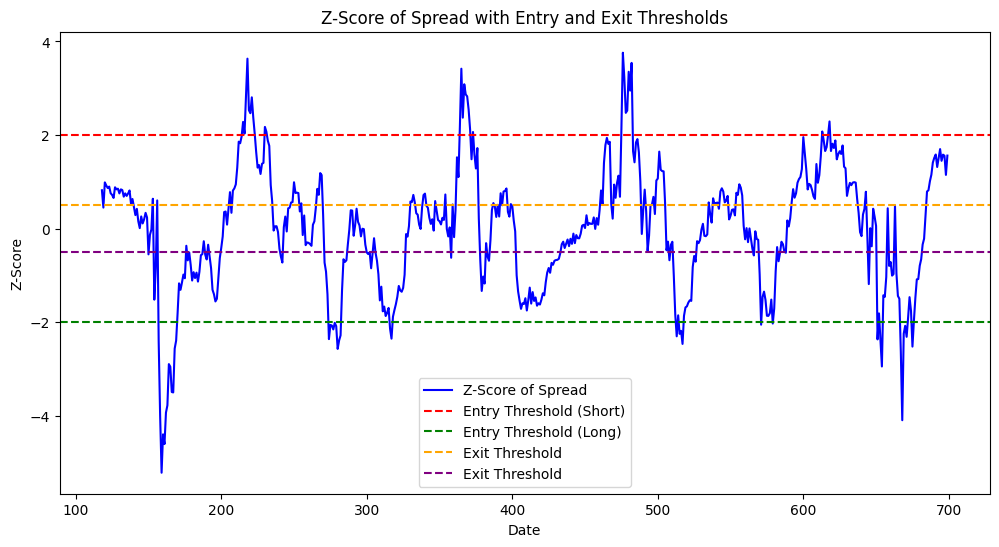

   entry_type  entry_index  exit_index  gross_return   fees  net_return
0        long          157         176     -0.000791  0.002   -0.002791
1       short          215         236      0.000500  0.002   -0.001500
2        long          274         287      0.000282  0.002   -0.001718
3        long          316         327      0.000611  0.002   -0.001389
4       short          364         377     -0.001116  0.002   -0.003116
5       short          475         489     -0.000511  0.002   -0.002511
6        long          513         527      0.000414  0.002   -0.001586
7        long          571         582     -0.000337  0.002   -0.002337
8       short          613         638      0.000353  0.002   -0.001647
9        long          651         658      0.000943  0.002   -0.001057
10       long          667         682     -0.000080  0.002   -0.002080
Total return: 0      0.000000
1      0.000000
2      0.000000
3      0.000000
4      0.000000
         ...   
695   -0.021732
696   -0.0

In [322]:
testX = close[symbol1].to_numpy()
testY = close[symbol2].to_numpy()
testResiduals = testY - (beta[0] + beta[1] * testX)
testResiduals = pd.Series(testResiduals)
testResiduals = zscore(testResiduals)
testResiduals = testResiduals.dropna()
backtest_results = backtest(testResiduals)
plt.figure(figsize=(12, 6))
plt.plot(backtest_results['zscore'], label='Z-Score of Spread', color='blue')
plt.axhline(2, color='red', linestyle='--', label='Entry Threshold (Short)')
plt.axhline(-2, color='green', linestyle='--', label='Entry Threshold (Long)')
plt.axhline(0.5, color='orange', linestyle='--', label='Exit Threshold')
plt.axhline(-0.5, color='purple', linestyle='--', label='Exit Threshold')
plt.title('Z-Score of Spread with Entry and Exit Thresholds')
plt.xlabel('Date')
plt.ylabel('Z-Score')
plt.legend()
plt.show()
trading_results, trade_pnls = simulate_trading(backtest_results, close, symbol1, symbol2, beta, slippage=0.0005, fees=0.0005)
print(trade_pnls)
print(f"Total return: {trading_results['equity']}")  # Return trade PnLs and final equity value